In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import lightgbm as lgbm
import warnings
import shap
shap.initjs()
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Feature_Selection.ipynb


# Data

In [2]:
X_train = []
X_test = []
y_train = []
y_test = []

sw = []
sw_zen = []
sw_isns = []
sw_eff = []

for num in range(1, 9):
    df = pd.read_csv('ICK_Active'+str(num)+'thdays.csv')
    X = df.drop(['UserID', 'Label', 'firstPaymentType', 'gapday'], axis = 1)
    y = df['Label']
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    sw_ = fc.BinarySampleWeights(train_x.shape[0], train_y)
    sw_zen_ = fc.BinarySampleWeights(train_x.shape[0], train_y, method = 'zen')
    sw_isns_ = fc.BinarySampleWeights(train_x.shape[0], train_y, method = 'isns')
    sw_eff_ = fc.BinarySampleWeights(train_x.shape[0], train_y, method = 'ens', beta = 0.99999)
    
    X_train.append(train_x), X_test.append(test_x)
    y_train.append(train_y), y_test.append(test_y)
    
    sw.append(sw_), sw_zen.append(sw_zen_)
    sw_isns.append(sw_isns_), sw_eff.append(sw_eff_)

# Models:

In [5]:
bl_model = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0][0], 1: sw_isns[0][1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)
def ratios(label):
    return sum(label == 0) / sum(label == 1)

tp_model = lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                                           reg_lambda=0.02,
                                           reg_alpha=0.02,
                                           scale_pos_weight=ratios(y_train[0]),
                                           min_child_weight=0.05,
                                           learning_rate=0.055,
                                           subsample=0.85,
                                           colsample_bytree=0.85,
                                           max_depth=3)

# Performance

In [24]:
metrics = ['accuracy', 'precisions', 'recalls', 'f1-scores', 'AUC_scores']

balanced = dict()
true_pos = dict()

for metric in metrics:
    balanced[metric] = []
    true_pos[metric] = []

In [27]:
for num in range(0, 8):
    bl_model.fit(X_train[num], y_train[num])
    balanced['accuracy'].append(round(accuracy_score(y_test[num], bl_model.predict(X_test[num])), 4))
    balanced['precisions'].append(round(precision_score(y_test[num], bl_model.predict(X_test[num])), 4))
    balanced['recalls'].append(round(recall_score(y_test[num], bl_model.predict(X_test[num])), 4))
    balanced['f1-scores'].append(round(f1_score(y_test[num], bl_model.predict(X_test[num])), 4))
    balanced['AUC_scores'].append(round(roc_auc_score(y_test[num], bl_model.predict(X_test[num])), 4))

In [28]:
for num in range(0, 8):
    tp_model.fit(X_train[num], y_train[num])
    true_pos['accuracy'].append(round(accuracy_score(y_test[num], tp_model.predict(X_test[num])), 4))
    true_pos['precisions'].append(round(precision_score(y_test[num], tp_model.predict(X_test[num])), 4))
    true_pos['recalls'].append(round(recall_score(y_test[num], tp_model.predict(X_test[num])), 4))
    true_pos['f1-scores'].append(round(f1_score(y_test[num], tp_model.predict(X_test[num])), 4))
    true_pos['AUC_scores'].append(round(roc_auc_score(y_test[num], tp_model.predict(X_test[num])), 4))

In [29]:
balanced

{'accuracy': [0.9278, 0.9318, 0.9339, 0.937, 0.9371, 0.9399, 0.9409, 0.943],
 'precisions': [0.4405, 0.4737, 0.4897, 0.5135, 0.5136, 0.5343, 0.5403, 0.556],
 'recalls': [0.4223, 0.467, 0.4971, 0.5267, 0.5417, 0.5665, 0.5854, 0.5981],
 'f1-scores': [0.4312, 0.4703, 0.4934, 0.52, 0.5273, 0.55, 0.562, 0.5762],
 'AUC_scores': [0.6926,
  0.7155,
  0.7306,
  0.7461,
  0.7531,
  0.7662,
  0.7755,
  0.7825]}

In [30]:
true_pos

{'accuracy': [0.8083, 0.8223, 0.8334, 0.844, 0.8529, 0.8621, 0.8682, 0.8727],
 'precisions': [0.2068, 0.2245, 0.2405, 0.2552, 0.269, 0.2848, 0.2959, 0.3053],
 'recalls': [0.6913, 0.7097, 0.7282, 0.7335, 0.7393, 0.7471, 0.75, 0.7573],
 'f1-scores': [0.3184, 0.3411, 0.3616, 0.3786, 0.3945, 0.4124, 0.4244, 0.4352],
 'AUC_scores': [0.7538, 0.7699, 0.7844, 0.7926, 0.8001, 0.8086, 0.8132, 0.819]}

In [21]:
action_day = list(range(1, 9))
action_day

[1, 2, 3, 4, 5, 6, 7, 8]

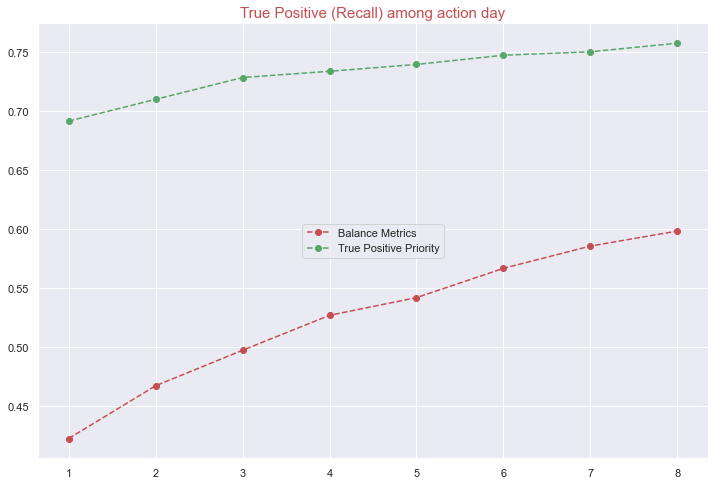

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(action_day, balanced['recalls'], '--bo', color='r', label='Balance Metrics')
plt.plot(action_day, true_pos['recalls'], '--bo', color='g', label='True Positive Priority')
plt.title('True Positive (Recall) among action day', fontsize=15, color='r')
plt.legend(loc=10);

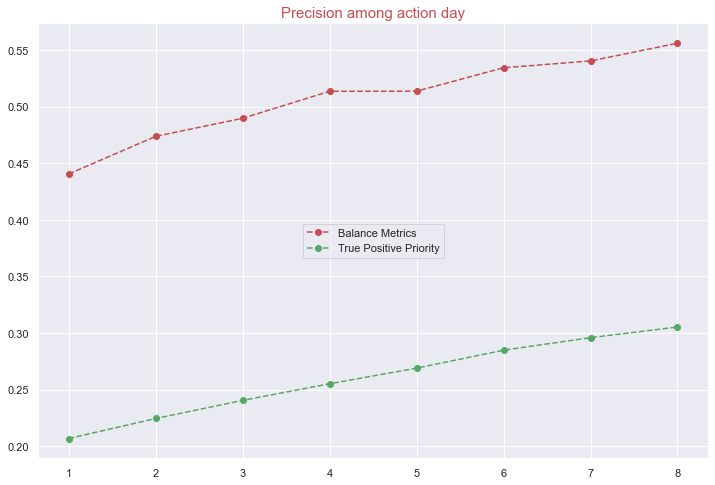

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(action_day, balanced['precisions'], '--bo', color='r', label='Balance Metrics')
plt.plot(action_day, true_pos['precisions'], '--bo', color='g', label='True Positive Priority')
plt.title('Precision among action day', fontsize=15, color='r')
plt.legend(loc=10);

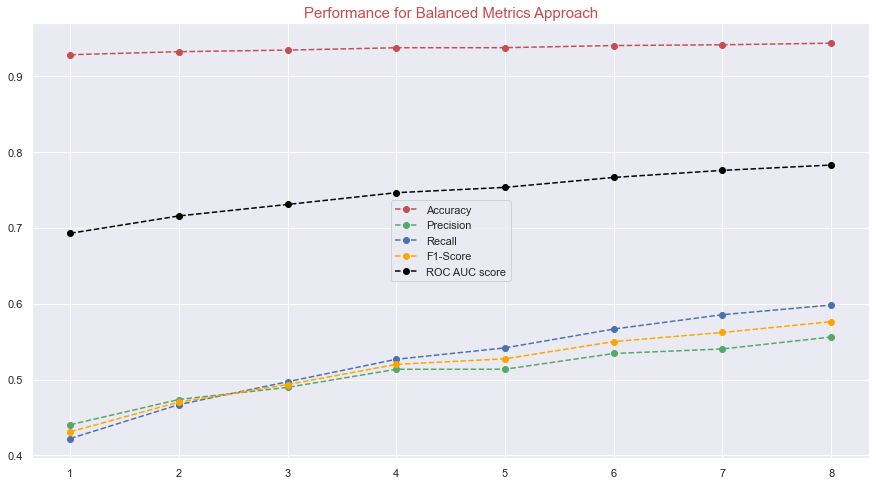

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(action_day, balanced['accuracy'], '--bo', color='r', label='Accuracy')
plt.plot(action_day, balanced['precisions'], '--bo', color='g', label='Precision')
plt.plot(action_day, balanced['recalls'], '--bo', color='b', label='Recall')
plt.plot(action_day, balanced['f1-scores'], '--bo', color='orange', label='F1-Score')
plt.plot(action_day, balanced['AUC_scores'], '--bo', color='black', label='ROC AUC score')
plt.title('Performance for Balanced Metrics Approach', fontsize=15, color='r')
plt.legend(loc=10);

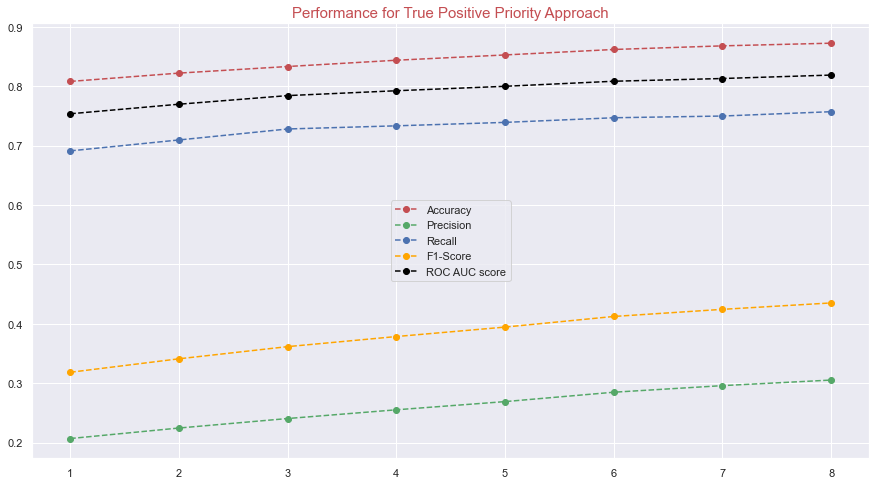

In [52]:
plt.figure(figsize=(15, 8))
plt.plot(action_day, true_pos['accuracy'], '--bo', color='r', label='Accuracy')
plt.plot(action_day, true_pos['precisions'], '--bo', color='g', label='Precision')
plt.plot(action_day, true_pos['recalls'], '--bo', color='b', label='Recall')
plt.plot(action_day, true_pos['f1-scores'], '--bo', color='orange', label='F1-Score')
plt.plot(action_day, true_pos['AUC_scores'], '--bo', color='black', label='ROC AUC score')
plt.title('Performance for True Positive Priority Approach', fontsize=15, color='r')
plt.legend(loc=10);

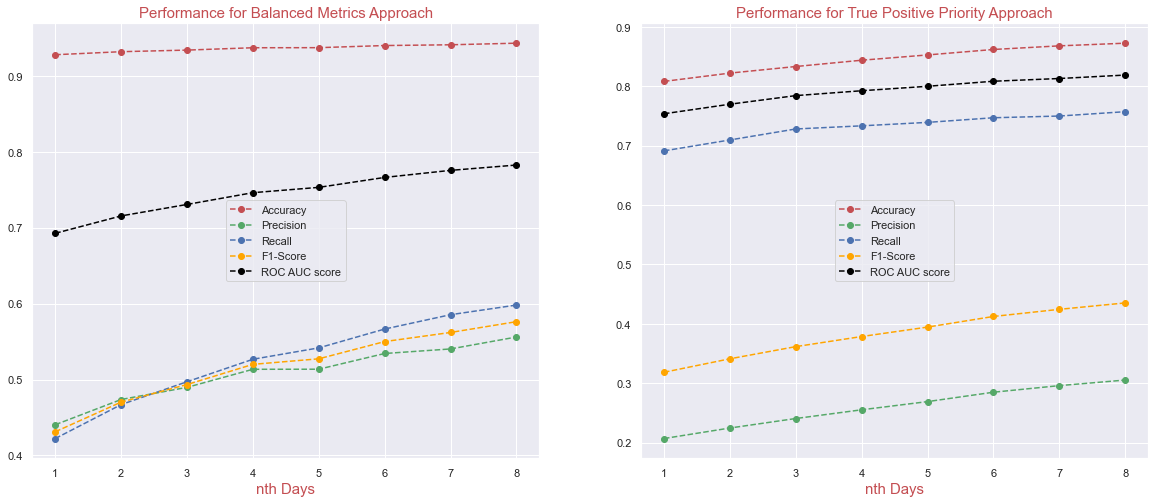

In [55]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(action_day, balanced['accuracy'], '--bo', color='r', label='Accuracy')
plt.plot(action_day, balanced['precisions'], '--bo', color='g', label='Precision')
plt.plot(action_day, balanced['recalls'], '--bo', color='b', label='Recall')
plt.plot(action_day, balanced['f1-scores'], '--bo', color='orange', label='F1-Score')
plt.plot(action_day, balanced['AUC_scores'], '--bo', color='black', label='ROC AUC score')
plt.xlabel('nth Days', fontsize=15, color='r')
plt.title('Performance for Balanced Metrics Approach', fontsize=15, color='r')
plt.legend(loc=10)
plt.subplot(122)
plt.plot(action_day, true_pos['accuracy'], '--bo', color='r', label='Accuracy')
plt.plot(action_day, true_pos['precisions'], '--bo', color='g', label='Precision')
plt.plot(action_day, true_pos['recalls'], '--bo', color='b', label='Recall')
plt.plot(action_day, true_pos['f1-scores'], '--bo', color='orange', label='F1-Score')
plt.plot(action_day, true_pos['AUC_scores'], '--bo', color='black', label='ROC AUC score')
plt.xlabel('nth Days', fontsize=15, color='r')
plt.title('Performance for True Positive Priority Approach', fontsize=15, color='r')
plt.legend(loc=10);

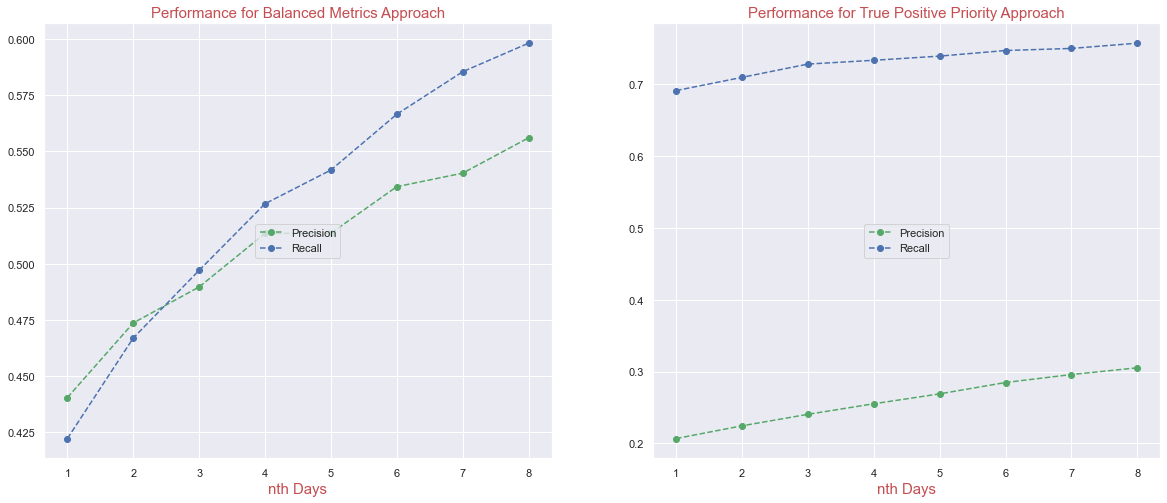

In [56]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
# plt.plot(action_day, balanced['accuracy'], '--bo', color='r', label='Accuracy')
plt.plot(action_day, balanced['precisions'], '--bo', color='g', label='Precision')
plt.plot(action_day, balanced['recalls'], '--bo', color='b', label='Recall')
# plt.plot(action_day, balanced['f1-scores'], '--bo', color='orange', label='F1-Score')
# plt.plot(action_day, balanced['AUC_scores'], '--bo', color='black', label='ROC AUC score')
plt.title('Performance for Balanced Metrics Approach', fontsize=15, color='r')
plt.xlabel('nth Days', fontsize=15, color='r')
plt.legend(loc=10)
plt.subplot(122)
# plt.plot(action_day, true_pos['accuracy'], '--bo', color='r', label='Accuracy')
plt.plot(action_day, true_pos['precisions'], '--bo', color='g', label='Precision')
plt.plot(action_day, true_pos['recalls'], '--bo', color='b', label='Recall')
# plt.plot(action_day, true_pos['f1-scores'], '--bo', color='orange', label='F1-Score')
# plt.plot(action_day, true_pos['AUC_scores'], '--bo', color='black', label='ROC AUC score')
plt.title('Performance for True Positive Priority Approach', fontsize=15, color='r')
plt.xlabel('nth Days', fontsize=15, color='r')
plt.legend(loc=10);

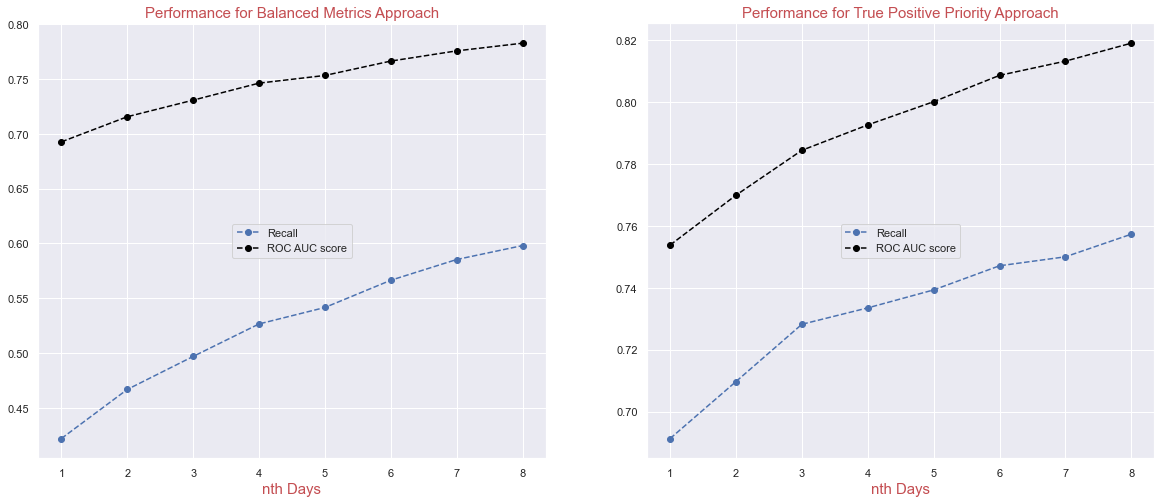

In [57]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
# plt.plot(action_day, balanced['accuracy'], '--bo', color='r', label='Accuracy')
# plt.plot(action_day, balanced['precisions'], '--bo', color='g', label='Precision')
plt.plot(action_day, balanced['recalls'], '--bo', color='b', label='Recall')
# plt.plot(action_day, balanced['f1-scores'], '--bo', color='orange', label='F1-Score')
plt.plot(action_day, balanced['AUC_scores'], '--bo', color='black', label='ROC AUC score')
plt.title('Performance for Balanced Metrics Approach', fontsize=15, color='r')
plt.xlabel('nth Days', fontsize=15, color='r')
plt.legend(loc=10)
plt.subplot(122)
# plt.plot(action_day, true_pos['accuracy'], '--bo', color='r', label='Accuracy')
# plt.plot(action_day, true_pos['precisions'], '--bo', color='g', label='Precision')
plt.plot(action_day, true_pos['recalls'], '--bo', color='b', label='Recall')
# plt.plot(action_day, true_pos['f1-scores'], '--bo', color='orange', label='F1-Score')
plt.plot(action_day, true_pos['AUC_scores'], '--bo', color='black', label='ROC AUC score')
plt.title('Performance for True Positive Priority Approach', fontsize=15, color='r')
plt.xlabel('nth Days', fontsize=15, color='r')
plt.legend(loc=10);